In [1]:
# standard modules
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import importlib

# PyTorch modules
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# (f)MRI modules
# import nibabel as nib
# import nilearn.image as nimg
# import nilearn.plotting as nplot
# import bids

# import data + model modules
from ukbb_package import ukbb_data
from ukbb_package import ukbb_ica_models
# in case of changes 
importlib.reload(ukbb_data)
importlib.reload(ukbb_ica_models)

# import custom functions
from ukbb_package import utils
# in case of changes
importlib.reload(utils)

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# prepare data paths
ukbb_dir = '/ritter/share/data/UKBB/ukb_data/'

In [3]:
torch.cuda.is_available()

True

In [4]:
utils.make_reproducible()

In [5]:
! gpustat

cuda02                      Thu Jun 22 12:17:57 2023  470.182.03
[0] NVIDIA GeForce RTX 3090 | 28'C,   0 % | 24040 / 24268 MB | tomasz(2873M) tomasz(13711M) tomasz(4869M) tomasz(2579M) gdm(4M)
[1] NVIDIA GeForce RTX 3090 | 30'C,   0 % |  3604 / 24268 MB | laurar(1799M) laurar(1797M) gdm(4M)
[2] NVIDIA GeForce RTX 3090 | 27'C,   0 % |     8 / 24268 MB | gdm(4M)
[3] NVIDIA GeForce RTX 3090 | 28'C,   0 % |     8 / 24268 MB | gdm(4M)


# Approach 1: Dataset + manual loader implementation
Dev code only; not used for actual analysis

In [6]:
g = torch.Generator()
g.manual_seed(43)

# initialise UKBB data
data = ukbb_data.UKBBDataset(ukbb_dir, all_data=False)
print(f'Available ICA25 data: {len(data)}')

# create train/test split samplers
batch_size = 10 #128
split_ratio = 0.8
## create indices
dataset_size = len(data)
indices = list(range(dataset_size))
split_index = int(np.floor(split_ratio * dataset_size))
## shuffle
np.random.seed(43)
np.random.shuffle(indices)
## get list of split indices, feed to samplers
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# load train/test data
train_loader = DataLoader(
                data,
                batch_size=batch_size,
                sampler=train_sampler,
                # drop_last=False,
                worker_init_fn=utils.seed_worker,
                generator=g,
                )
test_loader = DataLoader(
                data,
                batch_size=batch_size,
                sampler=test_sampler,
                # drop_last=False,
                worker_init_fn=utils.seed_worker,
                generator=g,
                )

Available ICA25 data: 100


In [7]:
data[0]

(tensor([[-1.8139, -1.8822, -2.0016,  ...,  0.4351,  0.3960,  0.4140],
         [ 3.3147,  2.3325,  1.8756,  ..., -0.2754, -0.6240, -0.4226],
         [ 1.2176,  0.6892,  0.6464,  ..., -1.2722, -1.1196, -0.7218],
         ...,
         [ 1.8535,  1.8548,  1.7175,  ..., -0.9533, -1.1425, -1.0926],
         [ 3.0506,  1.7800,  2.1955,  ..., -1.5257, -1.1038, -1.5390],
         [ 2.7041,  1.8542,  2.6583,  ..., -0.9206, -0.4617, -1.1548]]),
 tensor(61.))

In [8]:
# initialise model
simple_CNN = ukbb_ica_models.simple1DCNN()

# initialise trainer
trainer = pl.Trainer(accelerator='auto',
                     devices=1 if torch.cuda.is_available() else None,
                     max_epochs=2, 
                     deterministic=True)

# train the model
trainer.fit(simple_CNN, train_loader) 

# test the model
trainer.test(simple_CNN, test_loader)

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             3634.654296875
        test_mae            59.878318786621094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3634.654296875, 'test_mae': 59.878318786621094}]

In [9]:
trainer.test(simple_CNN, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             3634.654296875
        test_mae            59.878318786621094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3634.654296875, 'test_mae': 59.878318786621094}]

# Approach 2: Dataset + DataModule

### Test reproducibility
Run two dummy models to check that the datamodule / model set-up is reproducible across calls.

In [6]:
# define logging path
path = '../tracking/reproducibility/'

In [7]:
def test_reproducibility(log_path, data_path, model_name, device):
    """
    Fuction for using the same model, training and testing set-up for testing
    different learning rates.
    Outputs test score and a plot visualising the training progression.
    Input:
        log_path: path to where logs, checkpoints and data info should be saved
        data_path: path to data location
        model_name: name of model that is being trained, as str
        device: which GPU to run on
    Output:
        trainer: trained model
    """
    # initialise model
    simple_CNN = ukbb_ica_models.simple1DCNN()

    # initialise logger
    logger = utils.logger_init(save_dir=path+model_name+'/')

    checkpoint = utils.checkpoint_init(save_dir=path+model_name+'/')

    # initialise trainer
    trainer = utils.trainer_init(device, 
                                 logger, 
                                 log_steps=1, 
                                 max_epochs=6,
                                 callbacks=[checkpoint])
    
    # initialise DataModule
    data = ukbb_data.UKBBDataModule(data_path)
    
    # train model
    trainer.fit(simple_CNN, datamodule=data)
    print('Training complete.')
    print(f'\nTesting model {model_name}')
    
    # test model
    trainer.test(simple_CNN, datamodule=data)
    
    # save info on which data was used + what the train/val/test split was
    utils.save_data_info(path=path+model_name+'/', datamodule=data)
    
    # visualise training
    metrics = utils.get_current_metrics(trainer, show=True)
    utils.plot_training(data=metrics, title=f'Training visualisation of model {model_name}')
    
    return trainer

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision f

Sanity Checking: 0it [00:00, ?it/s]

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training complete.

Testing model 1


/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            63.4005012512207
        test_mae             6.629607200622559
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,step,train_loss,val_loss,val_mae,test_loss,test_mae
epoch,,,,,,
0,0,4071.103027,NaN,NaN,NaN,NaN
0,1,4126.632812,NaN,NaN,NaN,NaN
0,2,4037.807373,NaN,NaN,NaN,NaN
0,3,3806.037109,NaN,NaN,NaN,NaN
0,4,3930.080566,NaN,NaN,NaN,NaN


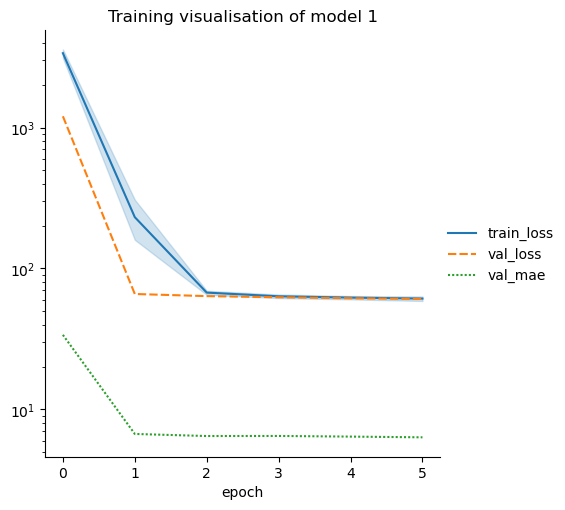

In [8]:
model_1 = test_reproducibility(path,ukbb_dir,"1",1)

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision f

Sanity Checking: 0it [00:00, ?it/s]

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training complete.

Testing model 2


/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            63.4005012512207
        test_mae             6.629607200622559
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,step,train_loss,val_loss,val_mae,test_loss,test_mae
epoch,,,,,,
0,0,4071.103027,NaN,NaN,NaN,NaN
0,1,4126.632812,NaN,NaN,NaN,NaN
0,2,4037.807373,NaN,NaN,NaN,NaN
0,3,3806.037109,NaN,NaN,NaN,NaN
0,4,3930.080566,NaN,NaN,NaN,NaN


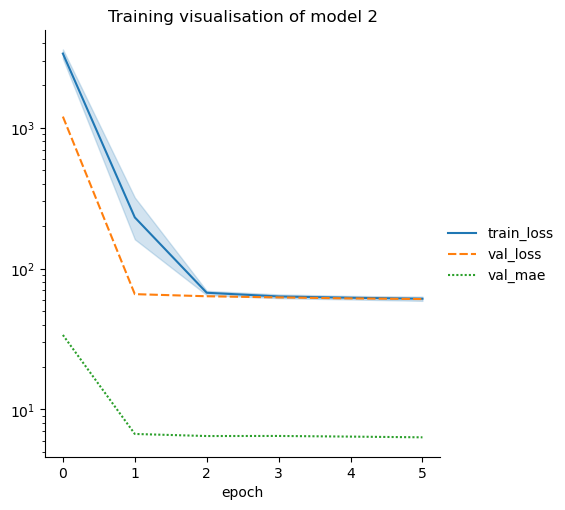

In [9]:
model_2 = test_reproducibility(path,ukbb_dir,"2",1)

Are the data splits the same?

In [10]:
for info_type in ['train_idx', 'val_idx', 'test_idx']:
    model_1_idx = set()
    model_2_idx = set()
    for model in ['1', '2']: 
        train_idx = utils.load_datainfo(path+model+'/', info_type)
        if model == '1':
            model_1_idx = set(train_idx)
        else:
            model_2_idx = set(train_idx)
    print(f'Items in model 1 {info_type} idx: {len(model_1_idx)}')
    print(f'Items in model 2 {info_type} idx: {len(model_2_idx)}')
    print(f'Shared amount of {info_type} idx: {len(model_1_idx.intersection(model_2_idx))}\n')

Items in model 1 train_idx idx: 4721
Items in model 2 train_idx idx: 4721
Shared amount of train_idx idx: 4721

Items in model 1 val_idx idx: 590
Items in model 2 val_idx idx: 590
Shared amount of val_idx idx: 590

Items in model 1 test_idx idx: 591
Items in model 2 test_idx idx: 591
Shared amount of test_idx idx: 591



Is the training identical?

In [11]:
metrics_1 = utils.get_current_metrics(model_1)
metrics_2 = utils.get_current_metrics(model_2)

metrics_1.equals(metrics_2)

True

Looks good!

## Initial model

In [16]:
# define logging path
path = '../tracking/ICA25/Initial1DCNN/'
# initialise model
simple_CNN = ukbb_ica_models.simple1DCNN(lr=1e-4)

# initialise logger
logger = utils.logger_init(save_dir=path)

# set callbacks
# no early stopping for first try
checkpoint = utils.checkpoint_init(save_dir=path)

# initialise trainer
trainer = utils.trainer_init(device=1, 
                             logger=logger,
                             max_epochs=250, # set a relatively high number to find out good patience
                             callbacks=[checkpoint])

# initialise DataModule
data = ukbb_data.UKBBDataModule(ukbb_dir)

# train model
trainer.fit(simple_CNN, datamodule=data)

# save info on which data was used + what the train/val/test split was
utils.save_data_info(path=path, datamodule=data)

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision f

Sanity Checking: 0it [00:00, ?it/s]

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [17]:
trainer.test(ckpt_path='best', datamodule=data)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/laurar/IM/tracking/ICA25/Initial1DCNN/Checkpoint/models-epoch=120-val_loss=40.38.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/laurar/IM/tracking/ICA25/Initial1DCNN/Checkpoint/models-epoch=120-val_loss=40.38.ckpt
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the n

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            34.41388702392578
        test_mae             4.697479724884033
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 34.41388702392578, 'test_mae': 4.697479724884033}]

Without context, a mean absolute error of ~4.7 years on the test set doesn't really give much information about how good or bad the best trained model really is. 

Let's check the mean absolute error if one only ever predicted the mean age from the training data:

In [18]:
# get targets (ages) of participants used in previous model
ages = data.data.labels['age']
# get train / test indices used in previous model
train_idx = data.train_idx
test_idx = data.test_idx
# get train / test ages
train_ages = ages.iloc[train_idx]
test_ages = ages.iloc[test_idx]

# calculate mean absolute error
np.mean(abs(train_ages.mean()-test_ages))

6.495416849007082

As we can see, the simple initial 1D CNN with a MAE of ~4.7 years already found a better strategy than just predicting the mean age, which would've led to a MAE of ~6.5 years.

How would a model perform that only predicted the mean age of the test set?

In [5]:
path = '../tracking/ICA25/Initial1DCNN/'

# read in used eids + ages
ages_df = utils.load_datainfo(path, 'overview')
# read in test idx
test_idx = utils.load_datainfo(path, 'test_idx')
# limit to test ages
test_ages = ages_df.iloc[test_idx]

# calculate mean absolute error
np.mean(abs(test_ages['age'].mean()-test_ages['age']))

6.590819426192664

The MAE would be even higher.

,step,train_loss,val_loss,val_mae,test_loss,test_mae
epoch,,,,,,
0,9,3868.896973,NaN,NaN,NaN,NaN
0,19,3580.623047,NaN,NaN,NaN,NaN
0,29,2782.714844,NaN,NaN,NaN,NaN
0,36,NaN,1201.345703,33.812698,NaN,NaN
1,39,767.315063,NaN,NaN,NaN,NaN


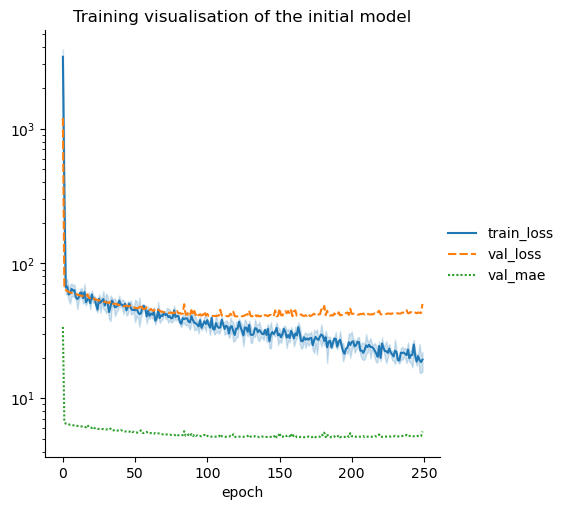

In [19]:
metrics = utils.get_current_metrics(trainer, show=True)
utils.plot_training(data=metrics, title='Training visualisation of the initial model')

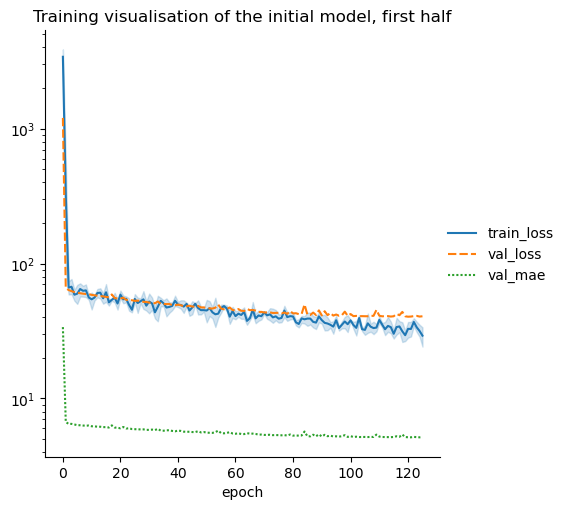

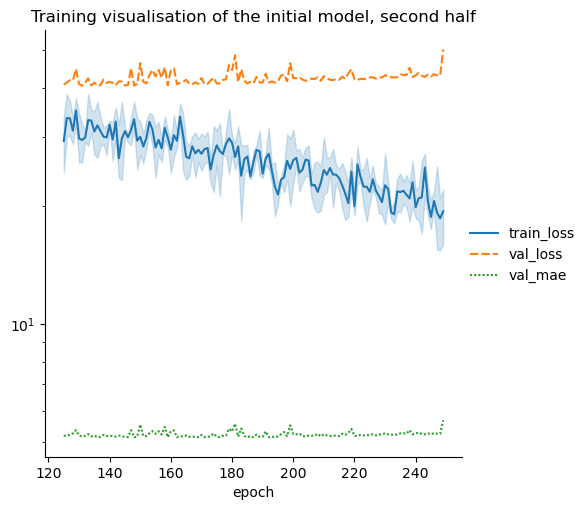

In [20]:
# zoom in a little
utils.plot_training(data=metrics, title='Training visualisation of the initial model, first half', xmax=125)
utils.plot_training(data=metrics, title='Training visualisation of the initial model, second half', xmin=125)

This visualisations show that while the train loss keeps decreasing, the validation loss actually increases a little again after about 120 epochs.

In order to stop the model from overfitting on the training data it is sensible to implement early stopping. 

## Finding good early stopping patience

During training, the model's performance was assessed by means of the validation loss. Therefore, locating the smallest validation loss means finding the epoch in which the model performed best during the training.

In [21]:
# find best epoch
metrics[metrics['val_loss'] == metrics['val_loss'].min()]

,step,train_loss,val_loss,val_mae,test_loss,test_mae
epoch,,,,,,
120,4476,NaN,40.383846,5.157156,NaN,NaN


Knowing epoch 120 was the best training epoch makes it possible to check what the longest period of epochs was after which a performance improvement was still achieved.

In [22]:
# longest period after which imporvement was still happening
# limit to val_loss entries
val_loss = metrics[metrics['val_loss'].notna() == True]
val_loss = val_loss['val_loss']
val_loss

epoch
0      1201.345703
1        65.909088
2        63.664936
3        62.485817
4        61.477032
          ...     
245      42.670761
246      43.277225
247      42.954376
248      42.872448
249      50.048466
Name: val_loss, Length: 250, dtype: float64

In [23]:
loss = 2000
current_patience = 0
patience = set()

for epoch in range(len(val_loss)):
    current_loss = val_loss.loc[epoch]
    if current_loss < loss:
        loss = current_loss
        patience.add(current_patience)
        current_patience = 0
    else:
        current_patience += 1

print(f'The biggest successful patience period covered {max(patience)} epochs.')
print(f'At the end of training, the validation loss hadn\'t improved for {current_patience} epochs.')

The biggest successful patience period covered 5 epochs.
At the end of training, the validation loss hadn't improved for 129 epochs.
